### Import and authentification

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g4__roi-0scA0BcVFzOdJJrgd3pa4YA4shPXqXlsk9W3n-EaQytKz0

Successfully saved authorization token.


### Global variables

In [3]:
import os
from google.cloud import storage

BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'JP_data_trainval_large_100_1000'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
#BATCH_SIZE = 16
# EPOCHS = 10
#BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']
   

### Data

#### X

In [4]:
from forest_guard.datas import get_image_landsat

# The image input data is a cloud-masked median composite.
image = get_image_landsat('2015-01-01', '2017-12-31')


# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.5
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.5
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Target

In [5]:
from forest_guard.datas import get_jaxa
jaxa = get_jaxa('2017-01-01', '2017-12-31')

palette = ['006400',
           'FEFF99',
            '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 3, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Stacking X and y

In [6]:
from forest_guard.datas import get_stacked_arrays

arrays = get_stacked_arrays(image, jaxa, BANDS, RESPONSE, KERNEL_SIZE)

### Areas of interests

In [1]:
# create our own areas of interests


# training features collection
rect_train = []
#massif central
rect_train.append(ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327]))
#west alpes
rect_train.append(ee.Geometry.Rectangle([5.7423828124999865,45.351141225773794, 8.291210937499986,46.633369678740046]))
#sweden
rect_train.append(ee.Geometry.Rectangle([12.158398437499986,57.85568314226695, 14.883007812499986,59.23144539808598]))
#sydney area
rect_train.append(ee.Geometry.Rectangle([150.04780273437498,-34.28117194241202, 151.47602539062498,-33.11122308232406]))

trainingPolys = ee.FeatureCollection(rect_train)

# eval features collections
rect_eval=[]
#west France
rect_eval.append(ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759]))
#east alpes
rect_eval.append(ee.Geometry.Rectangle([10.319052480734172,45.60830293723585, 13.527060293234172,47.511663948188954]))
#russia
rect_eval.append(ee.Geometry.Rectangle([29.61104466823417,57.26094864586795, 32.68721654323417,58.93274292154694]))
#australia
rect_eval.append(ee.Geometry.Rectangle([149.36943235990577,-37.37123372588969, 150.22636595365577,-36.73996965953723]))

evalPolys= ee.FeatureCollection(rect_eval)

NameError: name 'ee' is not defined

In [8]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Export data TFRecords

In [9]:
from forest_guard.datas import export_to_cloud_sampling_train_eval


export_to_cloud_sampling_train_eval(trainingPolys, evalPolys, arrays, 100, 1000, FOLDER)

{'state': 'READY', 'description': 'eval_patches_g3', 'creation_timestamp_ms': 1622281209398, 'update_timestamp_ms': 1622281209398, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'UASEOFHM7ZGFEBRLVFK5GEYC', 'name': 'projects/earthengine-legacy/operations/UASEOFHM7ZGFEBRLVFK5GEYC'}
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task 

Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Polling for task (id: UASEOFHM7ZGFEBRLVFK5GEYC).
Image export completed.


### Parse TFRecords and get back tensors

In [4]:
from forest_guard.parse import get_training_dataset

training = get_training_dataset(FOLDER)

#print(iter(training.take(1)).next())

In [5]:
a, b = iter(training.take(2)).next()

#### Data generation

In [5]:
from forest_guard.parse import get_training_dataset_gen

In [6]:
# import warnings
# warnings.filterwarnings('ignore')
training_gen = get_training_dataset_gen(FOLDER)

training_gen

/home/jprezler/.pyenv/versions/3.8.6/envs/forest_guards/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:938: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20, 256, 256, 9) (9 channels).
  warnings.warn(
/home/jprezler/.pyenv/versions/3.8.6/envs/forest_guards/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (20, 256, 256, 9) (9 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [7]:
images , labels = next(training_gen)
images.shape, labels.shape

((16, 256, 256, 9), (16, 256, 256, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


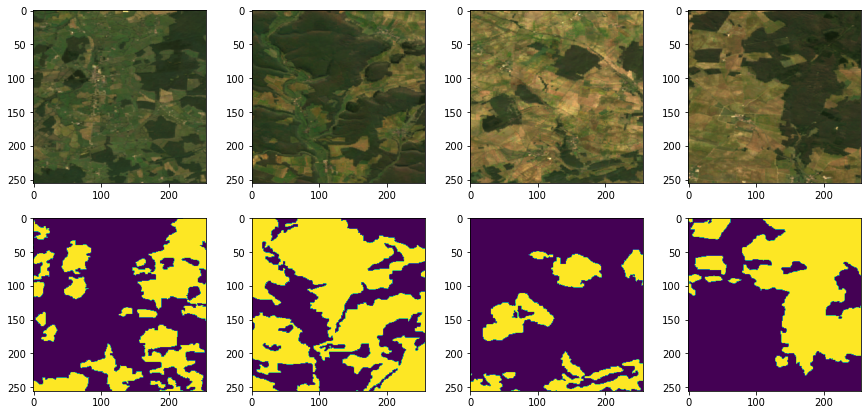

In [8]:
fig, axes = plt.subplots(2,4, figsize=(15,7))
   
for i in range(4):
    axes[0,i].imshow(np.flip(images[i, :, : , 1:4], axis=2)*5)
    axes[1,i].imshow(labels[i, :, : , :])
    

#### View images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


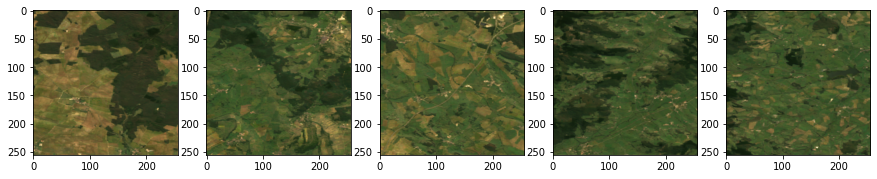

In [9]:
images , labels = iter(training.take(1)).next()

fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1, 5, i+1 )
    plt.imshow(np.flip(images[i, :, : , 1:4].numpy(), axis=2)*5)
    

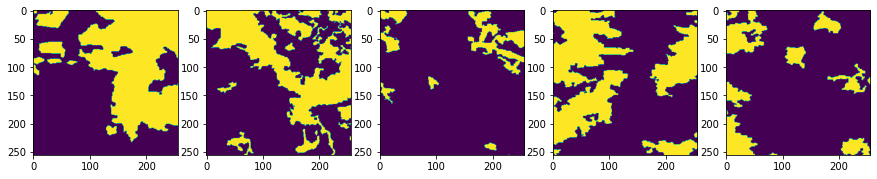

In [10]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(labels[i, :, : , :])


In [5]:
from forest_guard.parse import get_eval_dataset
evaluation = get_eval_dataset(FOLDER)

In [ ]:
print(iter(evaluation.take(1)).next())

In [12]:

from forest_guard.parse import get_eval_dataset_gen
evaluation_gen = get_eval_dataset_gen(FOLDER)

#### Evaluation augmentation

In [11]:
images , labels = next(evaluation_gen)
images.shape, labels.shape

((1, 256, 256, 9), (1, 256, 256, 1))

### Model

In [69]:
from forest_guard.trainer import Trainer


In [70]:
# train
print('\n', 'instantiate trainer')
trainer = Trainer('test_losses')


 instantiate trainer


In [7]:
from tensorflow.keras.metrics import MeanIoU
iou = MeanIoU(num_classes=2)

In [8]:
from forest_guard.losses import dice_loss
dice = dice_loss

In [9]:
from forest_guard.losses import tversky_loss
tversky = tversky_loss(0.75)

In [10]:
from forest_guard.losses import lovasz_softmax
lovasz = lovasz_softmax

In [71]:
print('\n', 'download model', '\n')
trainer.download_model_from_gcp()



 download model 



In [ ]:
trainer.model.summary()

In [ ]:

print('\n', 'run trainer', '\n')
history = trainer.run(training,
                      evaluation,
                      5,
                      metrics = [iou, "mae", "accuracy"], 
                      optimizer='adam',
                      loss=tversky,
                      train_size = 32,
                      eval_size=16,
                     patience=3)



 run trainer 

Epoch 1/5


In [19]:
# write metrics in ml flow
trainer.metrics_to_mlflow(history)


In [20]:
#save history on the cloud
trainer.save_history(history)

=> history save on cloud storage


In [24]:

# save model

print('\n', 'save model', '\n')
trainer.save_model()

=> history save on cloud storage

 save model 

INFO:tensorflow:Assets written to: gs://forest_guard_bucket/models/forest_guard/test_model/assets


=> history loaded from cloud storage


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

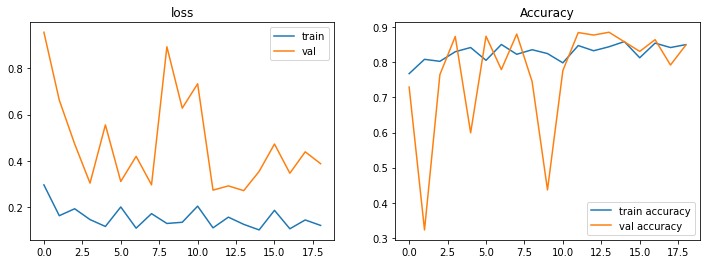

In [5]:
from forest_guard.history import get_history

hist = get_history('ai_platform_tversky')
hist

from forest_guard.history import plot_history_accuracy

plot_history_accuracy(hist)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

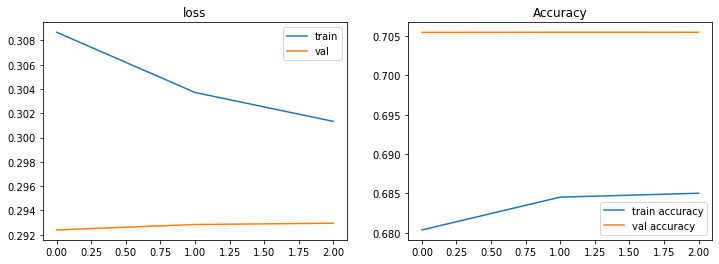

In [8]:
from forest_guard.history import get_history_colab
hist = get_history_colab('test_model')
plot_history_accuracy(hist)

In [ ]:
# def plot_history(history, title='', axs=None, exp_name=""):
#     if axs is not None:
#         ax1, ax2 = axs
#     else:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
#     if len(exp_name) > 0 and exp_name[0] != '_':
#         exp_name = '_' + exp_name
#     ax1.plot(history.history['loss'], label='train' + exp_name)
#     ax1.plot(history.history['val_loss'], label='val' + exp_name)
#     #ax1.set_ylim(0., 2.2)
#     ax1.set_title('loss')
#     ax1.legend()

#     ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
#     ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
#     #ax2.set_ylim(0.25, 1.)
#     ax2.set_title('Accuracy')
#     ax2.legend()
#     return (ax1, ax2)
# plot_history(history)

### Test metrics / losses

In [18]:
y_true = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 1]], dtype=np.float32)
y_pred = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]], dtype=np.float32)
test = ( y_true  ,  y_pred  )
from forest_guard.losses import iou

print ('iou_bespoke : ', iou(y_true, y_pred).numpy())

m = tf.keras.metrics.MeanIoU(num_classes=2)
acc = tf.keras.metrics.Accuracy()

acc.update_state(*test)

m.update_state(*test)

print ('iou : ', m.result().numpy())
print ('acc : ', acc.result().numpy())


y_true = np.expand_dims(y_true, axis=(2))
y_pred = np.expand_dims(y_pred, axis=(2))

print('dice loss : ', dice(y_true, y_pred).numpy())

print('tversky loss : ', tversky(y_true, y_pred).numpy())
zero = 0.0001
un = 0.999
y_pred = np.array([[zero, zero, zero, zero], [zero, zero, zero, zero], [zero, zero, un, zero], [zero, zero, zero, zero]], dtype=np.float32)

print('lovasz_softmax loss :', lovasz_softmax(y_true, y_pred).numpy())

iou_bespoke :  0.40625
iou :  0.40625
acc :  0.8125
dice loss :  1.0
tversky loss :  1.0
lovasz_softmax loss : 4.529249


In [12]:
from forest_guard.losses import iou

iou(y_true, y_pred).numpy()